In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import cv2
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier as AdaBoost
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from skimage.filters import gaussian as gsn
from sklearn import preprocessing, metrics, svm
from threading import Thread
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
DIRECTORY = r'C:\Users\RONI\Desktop\Python_Project\train'
IMG_SIZE = 50

In [3]:
x = []
y = []

for img_name in os.listdir(DIRECTORY):
    img_path = os.path.join(DIRECTORY, img_name)
    x.append(cv2.imread(img_path))
    y.append(img_name.split('.')[0])
y = np.array(y)

In [4]:
print(len(x))
print(len(y))

25000
25000


In [5]:
le = preprocessing.LabelEncoder()
le.fit(y)
y_encoded = le.transform(y)

In [6]:
img_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.1, random_state=42, shuffle=True,
                                                      stratify=y_encoded)

In [7]:
def images_trans(img_lst):
    new_img_lst = []
    
    for img in img_lst:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_arr = cv2.resize(gray_img, (IMG_SIZE, IMG_SIZE))
        # trans_img = preprocessing.normalize(img_arr)
        new_img_lst.append(img_arr)
    
    return new_img_lst

In [8]:
final_img_train = images_trans(img_train)
final_img_train = np.array(final_img_train)

In [9]:
def pca_transformation(pixels_arr):
    pca_img_lst = []
    for img in pixels_arr:
        pca = PCA(n_components=30)
        pca.fit(img)
        pca_img = pca.transform(img)
        pca_img_lst.append(pca_img)
    return np.array(pca_img_lst)

In [10]:
final_img_train[0].shape

(50, 50)

0


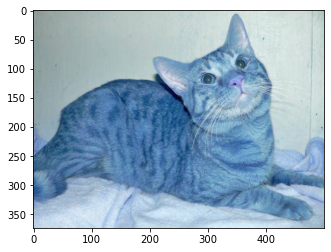

In [11]:
print(y_train[0])
plt.imshow(img_train[0])

(22500, 50, 50)

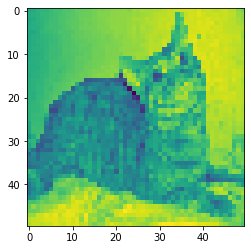

In [12]:
plt.imshow(final_img_train[0])
final_img_train.shape

In [16]:
pca_img_train = pca_transformation(final_img_train)
pca_img_train = pca_img_train.reshape(22500, pca_img_train.shape[1]*pca_img_train.shape[2])
pca_img_train.shape

(22500, 1500)

In [20]:
final_img_train = final_img_train.reshape(22500, final_img_train.shape[1]*final_img_train.shape[2])
x_train = pd.DataFrame(final_img_train)
x_train = pd.concat([x_train, pd.DataFrame(pca_img_train)], axis=1)
x_train

,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,151,155,161,163,164,168,172,173,177,179,...,0.049726,9.410091,-2.319882,4.226178,12.819630,-4.798388,-7.838839,-5.892498,-14.176208,-7.266376
1,66,70,71,74,76,77,46,153,99,98,...,-3.170017,-5.117329,-18.843219,4.127891,-7.345444,13.333147,11.055445,3.600296,3.404786,-3.928151
2,175,177,183,182,187,210,220,223,189,184,...,-7.442898,7.040701,8.305482,38.924428,15.360246,-9.454523,-28.234690,31.970514,-5.449775,16.533561
3,59,62,64,71,72,73,77,79,80,82,...,6.931632,-17.657364,-8.434736,-2.638088,14.357467,-10.229782,8.346523,22.951154,-2.800575,14.570310
4,45,67,60,22,22,24,24,6,25,69,...,-2.917373,-36.592596,26.237649,8.950324,20.853267,-0.496853,6.276044,2.033525,8.224660,-10.191303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22495,42,44,169,169,198,180,241,142,212,70,...,-6.476229,-64.270534,-35.489538,9.355709,-30.777945,-26.341270,-11.454962,-0.448840,6.567125,-32.958057
22496,158,156,156,155,155,159,159,160,163,160,...,-9.572758,-11.762166,-12.376866,-19.272542,6.393587,0.461832,19.717045,2.314774,2.775142,-6.889602
22497,63,62,58,58,60,59,63,58,64,65,...,-3.199132,6.860810,-3.506871,10.373044,-5.661328,-0.924745,-1.893120,-0.043529,0.339646,1.141583
22498,42,44,46,50,50,51,54,55,56,55,...,11.388097,20.853653,-3.646258,0.000031,2.931109,-0.453327,7.808836,1.934792,-2.036749,-2.929637


# building models

In [21]:
def trainModel(mdl, model_name, x_t, y_t, pred_l):
    m_predict = cross_val_predict(mdl,x_t,y_t)
    print(model_name + ": " + str(metrics.accuracy_score(y_t, m_predict)))
    pred_l.append(m_predict)

In [26]:
model1 = GaussianNB()
model2 = RandomForestClassifier(n_estimators=300)
model3 = DecisionTreeClassifier(random_state=42)
model4 = GradientBoostingClassifier(random_state=42)
model5 = VotingClassifier(estimators=[('mdl1', model1), ('mdl2', model4) , ('mdl3',model3)], voting='hard')

In [27]:
mdl_dict = {"GaussianNB":model1, "RandomForestClassifier": model2, "DecisionTreeClassifier":model3, "VotingClassifier":model4, 
       "GradientBoostingClassifier" :model5}
pred_lst = []
modelsThreads = []
for m_name, m in mdl_dict.items():
    t = Thread(target=trainModel, args=(m, m_name ,x_train, y_train, pred_lst))
    t.start()
    t.join()
    modelsThreads.append(t)

GaussianNB: 0.6399111111111111
RandomForestClassifier: 0.6752444444444444
DecisionTreeClassifier: 0.5628
VotingClassifier: 0.6718666666666666
GradientBoostingClassifier: 0.6604444444444444


In [28]:
cm = confusion_matrix(y_train, pred_lst[3])
cm_df = pd.DataFrame(cm,
                     index = ['cat', 'dog'], 
                     columns = ['cat', 'dog'])
cm

array([[7761, 3489],
       [3894, 7356]], dtype=int64)

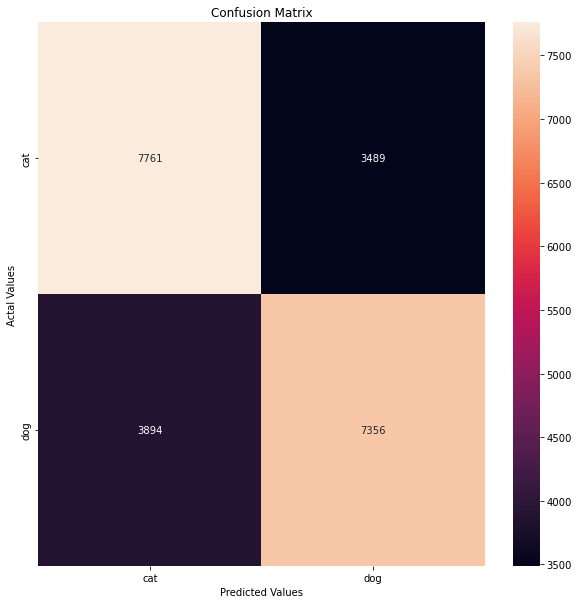

In [29]:
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [30]:
final_x_test = images_trans(x_test)
final_x_test = np.array(final_x_test)

In [31]:
pca_x_test = pca_x_test.reshape(2500, pca_x_test.shape[1]*pca_x_test.shape[2])
pca_x_test = pca_transformation(final_x_test)
final_img_train = final_img_train.reshape(22500, pca_x_test.shape[1]*pca_x_test.shape[2])

NameError: name 'pca_x_test' is not defined

In [ ]:
final_x_test = pd.DataFrame(final_x_test)
final_x_test = pd.concat([final_x_test, pd.DataFrame(pca_x_test)], axis=1)

In [ ]:
model = model5.fit(x_train, y_train)
final_pred = model.predict(final_x_test)
print(metrics.accuracy_score(y_test, final_pred))